In [2]:
# import teaspoon.ML.tents as tents
# # import TSAwithTDA.ML.test_tents as test_tents
# import teaspoon.MakeData.PointCloud as gPC
# import teaspoon.TDA.Persistence as pP

 
import re

import pandas as pd 
# from pandas import Series, DataFrame
import numpy as np
# from scipy.spatial.distance import euclidean, squareform
# from scipy import io
# #import statsmodels.api as sm
# #from patsy import dmatrices
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
from sklearn import metrics
# from sklearn.model_selection import cross_val_score
import os
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#--------Use Latex text for the figures
from matplotlib import rc, rcParams
    #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    # for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rcParams.update({'font.size': 12})
#--------

In [3]:
from imp import reload
reload(tents)

NameError: name 'tents' is not defined

In [4]:
Data = pd.read_csv('Uli_data.csv')


In [5]:
OneDgm = Data[Data.freq == 1]
OneDgm = OneDgm[OneDgm.trial == 5]
OneDgm.head()
# OneDgmDim1 = OneDgm[OneDgm.dim == 1]
# print(OneDgmDim1.columns)
# D = np.array(OneDgmDim1[['birth','death']])

# plt.scatter(D[:,0],D[:,1])
# plt.plot([0,200],[0,200])

,freq,trial,dim,birth,death
88669,1,5,-2,11.4570,36.0350
88670,1,5,-2,11.6030,36.0350
88671,1,5,-1,4.1397,36.0350
88672,1,5,0,4.1885,4.7006
88673,1,5,0,4.2057,4.7429


In [6]:
# Code to reshape the data in the groupby command below
def reshapeVec(g):
    A = np.array([g.dim,g.birth,g.death])
    A = A.T
    return A  

In [7]:
DgmsDF = Data.groupby(['freq', 'trial']).apply(reshapeVec)
DgmsDF = DgmsDF.reset_index()
DgmsDF = DgmsDF.rename(columns = {0:'CollectedDgm'})

In [8]:
DgmsDF.head()

,freq,trial,CollectedDgm
0,0,1,"[[-2.0, 63.375, 493.76], [-2.0, 74.82600000000..."
1,0,2,"[[-2.0, 42.301, 251.35], [-2.0, 44.12699999999..."
2,0,3,"[[-2.0, 24.084, 100.21], [-2.0, 24.43300000000..."
3,0,4,"[[-2.0, 16.221, 52.696999999999996], [-2.0, 16..."
4,0,5,"[[-2.0, 11.783, 36.272], [-2.0, 11.93, 36.272]..."


In [9]:
def getDgm(A, dim = 0):
    if type(dim) != str:
        A = A[np.where(A[:,0] == dim)[0],1:]
    elif dim == 'essential':
        A = A[np.where(A[:,0] <0)[0],:]
    return(A)

In [10]:
DgmsDF['Dgm1'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 1))
DgmsDF['Dgm0'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 0))
DgmsDF['DgmInf'] = DgmsDF.CollectedDgm.apply(lambda x: getDgm(x, dim = 'essential'))

In [11]:
DgmsDF.head()

,freq,trial,CollectedDgm,Dgm1,Dgm0,DgmInf
0,0,1,"[[-2.0, 63.375, 493.76], [-2.0, 74.82600000000...","[[59.183, 244.09], [59.518, 244.29], [60.372, ...","[[47.053999999999995, 71.388], [48.099, 50.716...","[[-2.0, 63.375, 493.76], [-2.0, 74.82600000000..."
1,0,2,"[[-2.0, 42.301, 251.35], [-2.0, 44.12699999999...","[[33.555, 251.35], [37.09, 37.137], [37.26, 37...","[[29.142, 38.969], [29.769000000000002, 30.07]...","[[-2.0, 42.301, 251.35], [-2.0, 44.12699999999..."
2,0,3,"[[-2.0, 24.084, 100.21], [-2.0, 24.43300000000...","[[15.835999999999999, 100.21], [19.13, 99.2320...","[[14.26, 19.491], [14.269, 14.397], [14.356, 1...","[[-2.0, 24.084, 100.21], [-2.0, 24.43300000000..."
3,0,4,"[[-2.0, 16.221, 52.696999999999996], [-2.0, 16...","[[7.8871, 52.696999999999996], [9.4849, 44.928...","[[7.2928, 9.4729], [7.3087, 7.3396], [7.3128, ...","[[-2.0, 16.221, 52.696999999999996], [-2.0, 16..."
4,0,5,"[[-2.0, 11.783, 36.272], [-2.0, 11.93, 36.272]...","[[4.7617, 36.272], [4.8185, 36.260999999999996...","[[4.3036, 4.3046], [4.3337, 4.7526], [4.431, 4...","[[-2.0, 11.783, 36.272], [-2.0, 11.93, 36.272]..."


In [12]:
max(set(DgmsDF.freq))
# min(set(DgmsDF.freq))

299

In [13]:
def label(index):
    if 0 <= index <= 19:
        return 'male_neutral'
    elif 20<= index <=39:
        return 'male_bodybuilder'
    elif 40<= index <=59:
        return 'male_fat'
    elif 60<= index <=79:
        return 'male_thin'
    elif 80<= index <=99:
        return 'male_average'
    elif 100<= index <=119:
        return 'female_neutral'
    elif 120<= index <=139:
        return 'female_bodybuilder'
    elif 140<= index <=159:
        return 'female_fat'
    elif 160<= index <=179:
        return 'female_thin'
    elif 180<= index <=199:
        return 'female_average'
    elif 200<= index <=219:
        return 'child_neutral'
    elif 220<= index <=239:
        return 'child_bodybuilder'
    elif 240<= index <=259:
        return 'child_fat'
    elif 260<= index <=279:
        return 'child_thin'
    elif 280<= index <=299:
        return 'child_average'
    else:
        print('What are you giving me?')

In [14]:
DgmsDF['TrainingLabel'] = DgmsDF.freq.apply(label)
DgmsDF= DgmsDF.sample(frac=1)
DgmsDF.head()

,freq,trial,CollectedDgm,Dgm1,Dgm0,DgmInf,TrainingLabel
2815,281,6,"[[-2.0, 7.9908, 25.000999999999998], [-2.0, 8....","[[4.3125, 21.71], [5.4946, 19.97], [5.5848, 24...","[[4.2822, 4.2822], [4.2835, 4.2836]]","[[-2.0, 7.9908, 25.000999999999998], [-2.0, 8....",child_average
670,67,1,"[[-2.0, 64.76100000000001, 510.15], [-2.0, 79....","[[61.641000000000005, 500.81], [61.71199999999...","[[47.958999999999996, 73.717], [48.26300000000...","[[-2.0, 64.76100000000001, 510.15], [-2.0, 79....",male_thin
341,34,2,"[[-2.0, 38.515, 255.87], [-2.0, 41.229, 255.87...","[[30.918000000000003, 255.87], [32.758, 32.768...","[[25.543000000000003, 39.163000000000004], [26...","[[-2.0, 38.515, 255.87], [-2.0, 41.229, 255.87...",male_bodybuilder
474,47,5,"[[-2.0, 10.32, 31.789], [-2.0, 10.65, 31.789],...","[[4.4472, 25.895], [4.8601, 31.693], [4.9449, ...","[[4.175, 4.6788], [4.2459, 4.4216], [4.2983, 4...","[[-2.0, 10.32, 31.789], [-2.0, 10.65, 31.789],...",male_fat
400,40,1,"[[-2.0, 50.155, 434.88], [-2.0, 60.215, 434.88...","[[49.294, 49.333999999999996], [49.45399999999...","[[33.602, 65.821], [43.166000000000004, 65.38]...","[[-2.0, 50.155, 434.88], [-2.0, 60.215, 434.88...",male_fat


In [15]:
len(DgmsDF)

3000

# Look at the diagrams

/home/lucho8908/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/lucho8908/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/lucho8908/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/lucho8908/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/lucho8908/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont

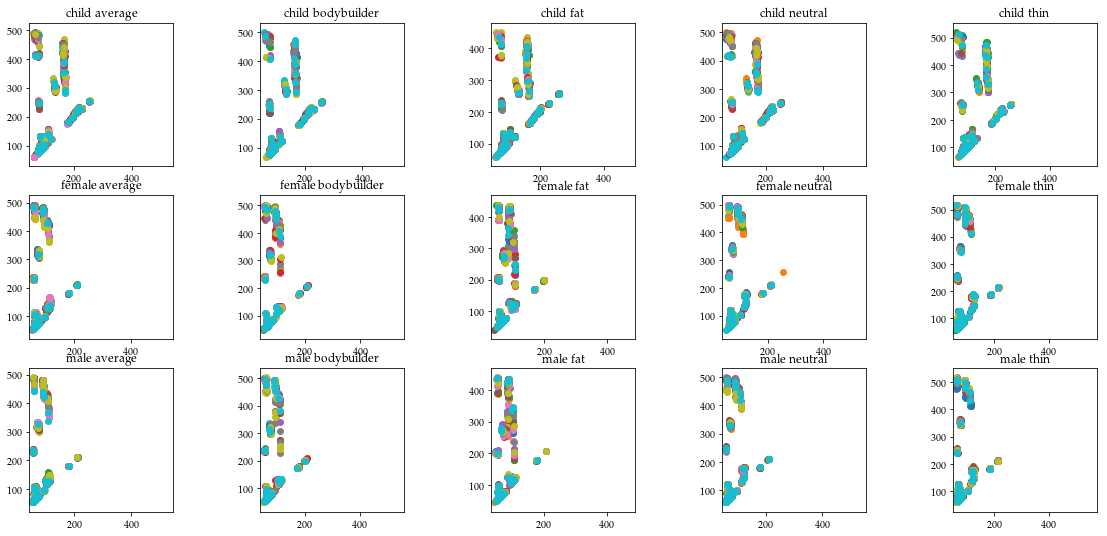

In [16]:
freq =1 
SampleDF = DgmsDF[DgmsDF.trial == freq].sample(frac=1)
labels = list(set(SampleDF.TrainingLabel))
labels.sort()

fig, AX = plt.subplots(3,5,figsize = (20,9))
for i,ax in enumerate(AX.flat):
# for i, label in enumerate():
    label = labels[i]
    SubsampleDF = SampleDF[SampleDF.TrainingLabel == label]

    ax.set_title(label.replace('_',' '))
#     ax.axis([0,50,0,50])
    for dgm in SubsampleDF.Dgm1:

        ax.scatter(dgm[:,0],dgm[:,1])
    ax.axis('square')

In [43]:
label  = labels[0]
label.replace('_', ' ')

'male bodybuilder'

# Run ML trials 

In [17]:
classes = [label(20*x) for x in range(15)]
# print(classes)

numTrials =10 
d = 20

scores = pd.DataFrame(columns = ['trial', 
                                 'freq',
                                 'trainScore1', 
                                 'testScore1', 
                                 'Confusion1',
                                 'alpha1',
                                 'trainScore2',
                                 'testScore2',
                                 'Confusion2',
                                 'alpha2'],
                     index = range(numTrials * 10))
counter = 0
for freq in range(1,11):
    for trial in range(numTrials):
        print('***')
        print('***')
        print('Counter:', counter, '/', numTrials*10)
        params = tents.ParameterBucket(d=d,
                               maxPower=1,
                               clfClass=lambda :RidgeClassifierCV(alphas = (1,10,100,1000))
#                                seed = 48864  
                                      )
        SampleDF = DgmsDF[DgmsDF.trial == freq].sample(frac=1)
        params.chooseDeltaEpsWithPadding(SampleDF.Dgm1,pad = .05)
        
        scores.trial[counter] = trial
        scores.freq[counter] = freq
    #     scores.loc['trial'] = t
        for deg in [1,2]:
            params.maxPower = deg
            out = tents.getPercentScore(SampleDF,
                            labels_col = 'TrainingLabel',
                           dgm_col = 'Dgm1', 
                           params = params,
                            verbose = False)
            scores.loc[counter]['trainScore' + str(deg)] = out['clf'].trainingScore
            scores.loc[counter]['testScore'  + str(deg)] = out['score']
            scores.loc[counter]['alpha'  + str(deg)] = out['clf'].alpha_

            C = metrics.confusion_matrix(out['DgmsDF'].dropna().TrainingLabel,
                                 out['DgmsDF'].dropna().Prediction,
                                labels = classes)
            scores.loc[counter]['Confusion'+str(deg)] = C
#         print(scores)
        counter += 1
    

***
***
Counter: 0 / 100
---
Beginning experiment.
Training estimator.
Score on training set: 0.820895522388.

Finished with train/test experiment.
---
Beginning experiment.
Training estimator.
Score on training set: 0.81592039801.

Finished with train/test experiment.
***
***
Counter: 1 / 100
---
Beginning experiment.
Training estimator.
Score on training set: 0.845771144279.

Finished with train/test experiment.
---
Beginning experiment.
Training estimator.
Score on training set: 0.860696517413.

Finished with train/test experiment.
***
***
Counter: 2 / 100
---
Beginning experiment.
Training estimator.
Score on training set: 0.860696517413.

Finished with train/test experiment.
---
Beginning experiment.
Training estimator.
Score on training set: 0.880597014925.

Finished with train/test experiment.
***
***
Counter: 3 / 100
---
Beginning experiment.
Training estimator.
Score on training set: 0.860696517413.

Finished with train/test experiment.
---
Beginning experiment.
Training estim

In [20]:
scores.head()

,trial,freq,trainScore1,testScore1,Confusion1,alpha1,trainScore2,testScore2,Confusion2,alpha2
0,0,1,0.820896,0.525253,"[[4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",10,0.81592,0.676768,"[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",1000
1,1,1,0.845771,0.505051,"[[2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",10,0.860697,0.59596,"[[4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",1000
2,2,1,0.860697,0.515152,"[[3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",10,0.880597,0.575758,"[[5, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",1000
3,3,1,0.860697,0.575758,"[[4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",10,0.985075,0.59596,"[[5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",100
4,4,1,0.835821,0.575758,"[[7, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]...",10,0.885572,0.545455,"[[2, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",1000


In [25]:
np.median(scores.alpha2)

10

In [29]:
scores.alpha1

0     10
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
18    10
19    10
20     1
21    10
22    10
23     1
24    10
25    10
26     1
27     1
28     1
29    10
      ..
70     1
71     1
72     1
73     1
74     1
75     1
76     1
77     1
78     1
79     1
80     1
81     1
82     1
83     1
84     1
85     1
86     1
87     1
88     1
89     1
90     1
91     1
92     1
93     1
94     1
95     1
96     1
97     1
98     1
99     1
Name: alpha1, Length: 100, dtype: object

In [30]:
tests1  = scores.groupby(['freq']).apply(lambda x : np.average(x.testScore1))
tests1var =scores.groupby(['freq']).apply(lambda x : x.testScore1.std()) 
alpha1 = scores.groupby(['freq']).apply(lambda x: x.alpha1.median())
trains1 = scores.groupby(['freq']).apply(lambda x : np.average(x.trainScore1))
trains1var =scores.groupby(['freq']).apply(lambda x : np.std(x.trainScore1)) 


tests2  = scores.groupby(['freq']).apply(lambda x : np.average(x.testScore2))
tests2var =scores.groupby(['freq']).apply(lambda x : np.std(x.testScore2)) 
trains2 = scores.groupby(['freq']).apply(lambda x : np.average(x.trainScore2))
trains2var =scores.groupby(['freq']).apply(lambda x : np.std(x.trainScore2)) 
alpha2 = scores.groupby(['freq']).apply(lambda x: x.alpha2.median())
avgScores = pd.DataFrame({ 'train1':trains1, 
                          'test1':tests1, 
                          'trains1var':trains1var,
                          'tests1var':tests1var,
                          'alpha1': alpha1,
                          'train2':trains2, 
                          'test2':tests2,
                          'trains2var':trains2var,
                          'tests2var':tests2var,
                          'alpha2':alpha2
                         }, 
            columns = ['train1','trains1var',
                       'test1', 'tests1var',
                       'alpha1',
                       'train2','trains2var',
                       'test2','tests2var',
                       'alpha2'
                      ])

avgScores

,train1,trains1var,test1,tests1var,alpha1,train2,trains2var,test2,tests2var,alpha2
freq,,,,,,,,,,
1,0.843781,0.020416,0.565657,0.048560,10.0,0.916418,0.061972,0.634343,0.055656,1000.0
2,0.829353,0.029437,0.509091,0.037554,10.0,0.950746,0.041948,0.608081,0.034343,100.0
3,0.927861,0.047368,0.644444,0.064905,5.5,1.000000,0.000000,0.845455,0.029639,10.0
4,0.952239,0.009227,0.838384,0.034991,1.0,0.994030,0.002985,0.908081,0.026896,10.0
5,0.951741,0.010448,0.887879,0.026704,1.0,0.990547,0.005194,0.918182,0.023667,10.0
6,0.966667,0.005000,0.946465,0.012643,1.0,0.991045,0.009647,0.933333,0.018182,1.0
7,0.971144,0.007312,0.937374,0.019517,1.0,0.993035,0.006371,0.943434,0.022222,1.0
8,0.948259,0.008384,0.916162,0.023352,1.0,0.981095,0.015383,0.903030,0.023989,1.0
9,0.950746,0.009557,0.885859,0.025664,1.0,0.983582,0.003886,0.897980,0.023232,1.0


In [36]:
np.std(scores.testScore1)

0.18500341247193963

In [38]:
trains1var =scores.groupby(['freq']).apply(lambda x : np.std(x.trainScore1)) 
trains1var

freq
1     0.019656
2     0.030653
3     0.043215
4     0.012743
5     0.015423
6     0.011002
7     0.005473
8     0.007036
9     0.011356
10    0.030974
dtype: float64

In [ ]:
avgScores.to_csv('ShapeDataScores_10Trials_d20.csv', sep = '&')

In [159]:
# scores.to_csv('ShapeDataScores30.csv')

In [23]:
classes = [label(20*x) for x in range(15)]
# print(classes)

d = 20
freq = 2

params = tents.ParameterBucket(d=d,
               maxPower=1,
               clfClass=lambda :RidgeClassifier(alpha = 0),
               seed = 48864   )
SampleDF = DgmsDF[DgmsDF.trial == freq].sample(frac=1)
params.chooseDeltaEpsWithPadding(SampleDF.Dgm1,pad = .05)
        

out = tents.getPercentScore(SampleDF,
                labels_col = 'TrainingLabel',
               dgm_col = 'Dgm1', 
               params = params)

---
Beginning experiment.
Variables in parameter bucket
---
description : 
d : 20
delta : 11.9018
epsilon : 0.0
maxPower : 1
clfClass : <function <lambda> at 0x7fbb7ab88bf8>
seed : 48864
test_size : 0.33
---

Using 201/300 to train...
Training estimator.
Making G...
Number of features used is 420 ...
Checking score on training set...
Score on training set: 0.970149253731.

Using 99/300 to test...
Score on testing set: 0.626262626263...

Finished with train/test experiment.


/home/muncheli/Programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


(15, 420)


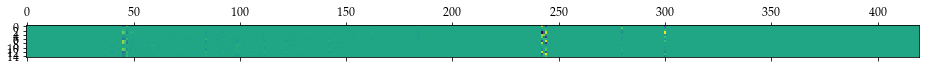

In [27]:
A = out['clf'].coef_
print(np.shape(A))
plt.matshow(A)

In [28]:
SampleDF = out['DgmsDF'].dropna()
SampleDF

,freq,trial,CollectedDgm,Dgm1,Dgm0,DgmInf,TrainingLabel,Prediction
751,75,2,"[[-2.0, 42.544, 266.62], [-2.0, 45.118, 266.62...","[[30.676, 30.678], [35.537, 266.62], [38.396, ...","[[28.692, 38.867], [28.695, 28.71], [28.914, 3...","[[-2.0, 42.544, 266.62], [-2.0, 45.118, 266.62...",male_thin,male_thin
2111,211,2,"[[-2.0, 43.839, 195.1], [-2.0, 45.582, 195.1],...","[[32.054, 195.1], [36.727, 193.71], [37.826, 1...","[[28.312, 36.825], [29.251, 30.911], [31.93, 3...","[[-2.0, 43.839, 195.1], [-2.0, 45.582, 195.1],...",child_neutral,child_average
1641,164,2,"[[-2.0, 42.485, 261.71], [-2.0, 45.615, 261.71...","[[32.2, 261.71], [37.307, 235.46], [37.724, 13...","[[29.098, 39.533], [29.449, 37.07], [29.902, 3...","[[-2.0, 42.485, 261.71], [-2.0, 45.615, 261.71...",female_thin,female_thin
2001,200,2,"[[-2.0, 43.659, 192.85], [-2.0, 45.475, 192.85...","[[28.602, 192.85], [37.082, 191.91], [37.33, 1...","[[26.315, 26.633], [26.322, 26.326], [27.539, ...","[[-2.0, 43.659, 192.85], [-2.0, 45.475, 192.85...",child_neutral,child_neutral
1111,111,2,"[[-2.0, 42.866, 252.46], [-2.0, 45.019, 252.46...","[[34.262, 252.46], [36.385, 36.398], [36.686, ...","[[26.176, 39.67], [28.548, 35.219], [29.304, 3...","[[-2.0, 42.866, 252.46], [-2.0, 45.019, 252.46...",female_neutral,female_neutral
971,97,2,"[[-2.0, 42.065, 246.82], [-2.0, 43.147, 246.82...","[[33.19, 246.82], [36.635, 36.636], [36.85, 36...","[[29.008, 38.243], [29.159, 30.622], [29.53, 3...","[[-2.0, 42.065, 246.82], [-2.0, 43.147, 246.82...",male_average,male_average
2491,249,2,"[[-2.0, 43.136, 176.21], [-2.0, 45.415, 176.21...","[[28.951, 29.105], [31.282, 176.21], [33.944, ...","[[27.894, 29.85], [28.449, 28.492], [28.508, 2...","[[-2.0, 43.136, 176.21], [-2.0, 45.415, 176.21...",child_fat,child_fat
921,92,2,"[[-2.0, 42.254, 245.05], [-2.0, 43.202, 245.05...","[[32.848, 245.05], [37.601, 37.616], [37.63, 1...","[[28.991, 39.173], [29.391, 36.66], [29.772, 3...","[[-2.0, 42.254, 245.05], [-2.0, 43.202, 245.05...",male_average,female_average
2271,227,2,"[[-2.0, 43.672, 188.05], [-2.0, 45.508, 188.05...","[[30.562, 188.05], [37.315, 40.428], [37.339, ...","[[26.672, 36.962], [30.064, 36.89], [30.071, 3...","[[-2.0, 43.672, 188.05], [-2.0, 45.508, 188.05...",child_bodybuilder,child_bodybuilder
2531,253,2,"[[-2.0, 43.01, 175.34], [-2.0, 45.235, 175.34]...","[[26.531, 26.541], [33.263, 175.34], [35.472, ...","[[26.493, 27.291], [26.521, 26.527], [26.524, ...","[[-2.0, 43.01, 175.34], [-2.0, 45.235, 175.34]...",child_fat,child_fat


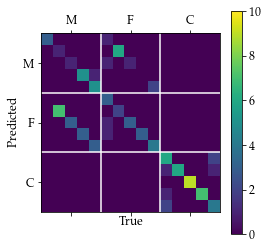

In [38]:
C = metrics.confusion_matrix(out['DgmsDF'].dropna().TrainingLabel,
                     out['DgmsDF'].dropna().Prediction,
                    labels = classes)
# tick_marks = np.arange(len(classes))
tick_marks = [2,7,12]
labels = ['M','F','C']
# blankLabels = ['' for x in tick_marks]


# f= plt.figure()

# C = scores.loc[i]['Confusion1']
im = plt.matshow(C, vmin = 0, vmax = 10)
ax = plt.gca()
ax.set_xticks(tick_marks)
ax.set_xticklabels(labels)
ax.set_yticks(tick_marks)
ax.set_yticklabels(labels)

ax.set_xlabel('True')
ax.set_ylabel('Predicted')

ax.plot([-.5,14.5],[4.5,4.5],c='white')
ax.plot([-.5,14.5],[9.5,9.5],c='white')
ax.plot([4.5,4.5],[-.5,14.5],c='white')
ax.plot([9.5,9.5],[-.5,14.5],c='white')

plt.colorbar(im)

In [ ]:
# Get out the confusion matrix for the training

D_test = 

## Read back in the shapes csv

In [87]:
def ReadStringArray(C):
    C = [x for x in C.split('[') if not x == '']
    C = [x.replace(']', '').replace('\n', '') for x in C]
    C = [x.strip() for x in C]
    C = [list(map(int,x.split())) for x in C]
    C = np.array(C)
    return C

In [85]:
scoresCSV = pd.read_csv('ShapeDataScores.csv')
scoresCSV.Confusion1 = scoresCSV.Confusion1.apply(ReadStringArray)
scoresCSV.Confusion2 = scoresCSV.Confusion2.apply(ReadStringArray)

,Unnamed: 0,trainScore1,testScore1,Confusion1,trainScore2,testScore2,Confusion2
0,1,0.746269,0.565657,[[ 1 0 0 0 0 6 0 0 0 0 0 0 0 0 0...,0.930348,0.636364,[[ 3 0 0 0 0 4 0 0 0 0 0 0 0 0 0...
1,2,0.810945,0.444444,[[3 0 0 0 0 2 0 0 0 0 0 0 0 0 0]\n [0 4 0 0 0 ...,0.975124,0.636364,[[ 3 0 0 0 0 2 0 0 0 0 0 0 0 0 0...
2,3,0.830846,0.515152,[[ 0 0 0 1 5 3 0 0 0 0 0 0 0 0 0...,0.980100,0.666667,[[4 0 0 0 0 5 0 0 0 0 0 0 0 0 0]\n [0 1 0 0 0 ...
3,4,0.830846,0.616162,[[1 0 0 4 0 0 2 0 0 6 0 0 0 0 0]\n [0 8 0 0 0 ...,0.975124,0.808081,[[7 0 0 2 0 1 1 0 0 2 0 0 0 0 0]\n [0 9 0 0 0 ...
4,5,0.905473,0.808081,[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 5 0 0 0 ...,0.955224,0.868687,[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 4 0 0 0 ...


In [90]:
classes = [label(20*x) for x in range(15)]
classes = [c.replace('_',' ') for c in classes]
# print(classes)


['male neutral', 'male bodybuilder', 'male fat', 'male thin', 'male average', 'female neutral', 'female bodybuilder', 'female fat', 'female thin', 'female average', 'child neutral', 'child bodybuilder', 'child fat', 'child thin', 'child average']


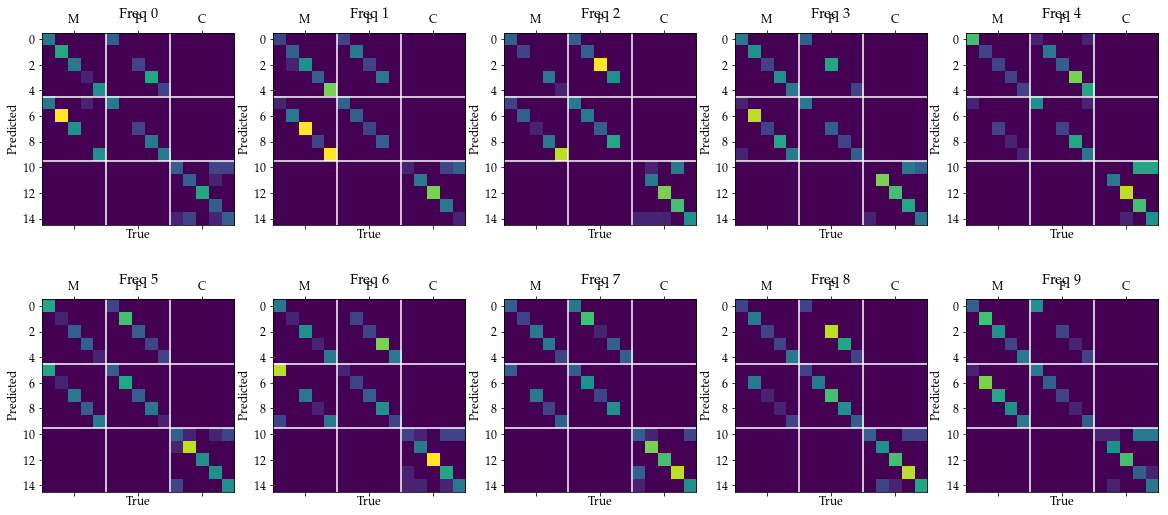

In [65]:

fig, AX = plt.subplots(2,5,figsize = (20,9))

# tick_marks = np.arange(len(classes))
tick_marks = [2,7,12]
labels = ['M','F','C']
# blankLabels = ['' for x in tick_marks]


for i,ax in enumerate(AX.flat):

    C = scores.loc[i]['Confusion1']
    im = ax.matshow(C, vmin = 0, vmax = 10)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels)
#     plt.colorbar(im)
#     for xlabel_i in ax.get_xticklabels():
#         xlabel_i.set_visible(False)
#         xlabel_i.set_fontsize(0.0)
#     for xlabel_i in ax.get_yticklabels():
#         xlabel_i.set_visible(False)
#         xlabel_i.set_fontsize(0.0)

    ax.set_title('Freq ' + str(i))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    ax.plot([-.5,14.5],[4.5,4.5],c='white')
    ax.plot([-.5,14.5],[9.5,9.5],c='white')
    ax.plot([4.5,4.5],[-.5,14.5],c='white')
    ax.plot([9.5,9.5],[-.5,14.5],c='white')

plt.savefig('Shapes_ConfusionMatrices.pdf', bbox_inches = 'tight')

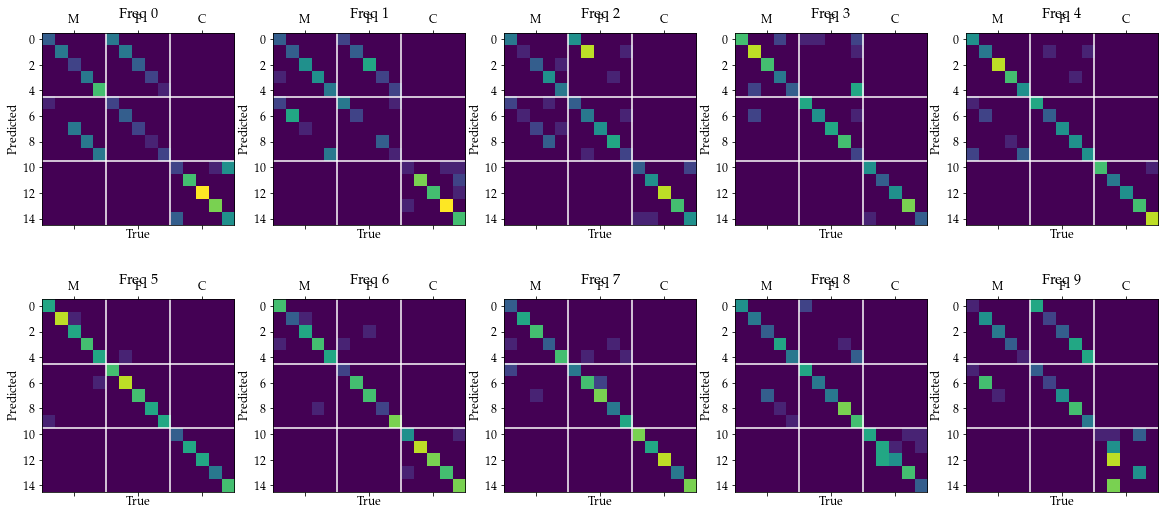

In [131]:

fig, AX = plt.subplots(2,5,figsize = (20,9))

# tick_marks = np.arange(len(classes))
tick_marks = [2,7,12]
labels = ['M','F','C']
# blankLabels = ['' for x in tick_marks]


for i,ax in enumerate(AX.flat):

    C = scoresCSV.loc[i]['Confusion2']
    im = ax.matshow(C, vmin = 0, vmax = 10)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels)
#     plt.colorbar(im)
#     for xlabel_i in ax.get_xticklabels():
#         xlabel_i.set_visible(False)
#         xlabel_i.set_fontsize(0.0)
#     for xlabel_i in ax.get_yticklabels():
#         xlabel_i.set_visible(False)
#         xlabel_i.set_fontsize(0.0)

    ax.set_title('Freq ' + str(i))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    ax.plot([-.5,14.5],[4.5,4.5],c='white')
    ax.plot([-.5,14.5],[9.5,9.5],c='white')
    ax.plot([4.5,4.5],[-.5,14.5],c='white')
    ax.plot([9.5,9.5],[-.5,14.5],c='white')

plt.savefig('Shapes_ConfusionMatrices2.pdf', bbox_inches = 'tight')

# Train just on adults

In [80]:
# classes = [label(20*x) for x in range(15)]
# print(classes)

d = 20
freq = 3

params = tents.ParameterBucket(d=d,
               maxPower=1,
               clfClass=lambda :RidgeClassifier(alpha = 0),
               seed = 48864   )
SampleDF = DgmsDF[DgmsDF.trial == freq].sample(frac=1)
SampleDF = SampleDF[SampleDF['TrainingLabel'].str.contains('male')] 
params.chooseDeltaEpsWithPadding(SampleDF.Dgm1,pad = .05)
        

out = tents.getPercentScore(SampleDF,
                labels_col = 'TrainingLabel',
               dgm_col = 'Dgm1', 
               params = params)

---
Beginning experiment.
Variables in parameter bucket
---
description : 
d : 20
delta : 4.6865499999999995
epsilon : 0.0
maxPower : 1
clfClass : <function <lambda> at 0x7f9c99124ae8>
seed : 48864
test_size : 0.33
---

Using 134/200 to train...
Training estimator.
Making G...
Number of features used is 420 ...
Checking score on training set...
Score on training set: 1.0.

Using 66/200 to test...
Score on testing set: 0.606060606061...

Finished with train/test experiment.


/home/muncheli/Programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [75]:

DgmsDF[DgmsDF['TrainingLabel'].str.contains('male')]

,freq,trial,CollectedDgm,Dgm1,Dgm0,DgmInf,TrainingLabel
1400,140,1,"[[-2.0, 50.026, 434.84], [-2.0, 61.415, 434.84...","[[51.821, 52.057], [51.852, 52.097], [52.225, ...","[[35.614, 65.48], [42.168, 64.679], [43.102, 4...","[[-2.0, 50.026, 434.84], [-2.0, 61.415, 434.84...",female_fat
603,60,4,"[[-2.0, 16.723, 54.529], [-2.0, 16.725, 54.529...","[[7.9957, 54.529], [9.4898, 45.606], [9.695, 4...","[[7.4577, 9.5706], [7.4605, 7.461], [7.4623, 7...","[[-2.0, 16.723, 54.529], [-2.0, 16.725, 54.529...",male_thin
1448,144,9,"[[-2.0, 1.4304, 2.795], [-2.0, 1.4371, 2.795],...","[[1.215, 2.795], [1.2493, 2.5069], [1.3851, 2....","[[1.209, 1.2118], [1.2118, 1.2118], [1.4333, 1...","[[-2.0, 1.4304, 2.795], [-2.0, 1.4371, 2.795],...",female_fat
1807,180,8,"[[-2.0, 2.4381, 6.9075], [-2.0, 2.4811, 6.9075...","[[1.4869, 6.7952], [1.6286, 6.7935], [2.0162, ...","[[1.4828, 1.4868], [1.4868, 1.4868]]","[[-2.0, 2.4381, 6.9075], [-2.0, 2.4811, 6.9075...",female_average
171,17,2,"[[-2.0, 42.122, 250.27], [-2.0, 43.773, 250.27...","[[33.777, 250.27], [37.887, 37.897], [37.907, ...","[[28.757, 38.164], [29.054, 37.882], [29.537, ...","[[-2.0, 42.122, 250.27], [-2.0, 43.773, 250.27...",male_neutral
1537,153,8,"[[-2.0, 1.9989, 6.0008], [-2.0, 2.0525, 6.0008...","[[1.3089, 6.0008], [1.3855, 1.3856], [1.4208, ...","[[1.2929, 1.2964]]","[[-2.0, 1.9989, 6.0008], [-2.0, 2.0525, 6.0008...",female_fat
958,95,9,"[[-2.0, 1.5865, 3.2801], [-2.0, 1.5921, 3.2801...","[[1.3836, 3.2801], [1.4042, 3.0894], [1.5258, ...","[[1.3776, 1.381]]","[[-2.0, 1.5865, 3.2801], [-2.0, 1.5921, 3.2801...",male_average
14,1,5,"[[-2.0, 11.457, 36.035], [-2.0, 11.603, 36.035...","[[4.754, 36.035], [4.8505, 30.024], [5.0532, 3...","[[4.1885, 4.7006], [4.2057, 4.7429], [4.4302, ...","[[-2.0, 11.457, 36.035], [-2.0, 11.603, 36.035...",male_neutral
602,60,3,"[[-2.0, 24.518, 103.51], [-2.0, 25.015, 103.51...","[[15.962, 103.51], [19.126, 102.94], [19.189, ...","[[14.308, 19.769], [14.427, 14.455], [14.439, ...","[[-2.0, 24.518, 103.51], [-2.0, 25.015, 103.51...",male_thin
531,53,2,"[[-2.0, 36.596, 222.29], [-2.0, 40.185, 222.29...","[[34.978, 222.29], [35.484, 35.491], [36.312, ...","[[27.998, 38.733], [28.233, 38.839], [28.278, ...","[[-2.0, 36.596, 222.29], [-2.0, 40.185, 222.29...",male_fat


# Old

In [134]:
classes = [label(20*x) for x in range(15)]
print(classes)

scores = pd.DataFrame(columns = [#'trial', 
                                 'trainScore1', 
                                 'testScore1', 
                                 'Confusion1',
                                 'trainScore2',
                                 'testScore2',
                                 'Confusion2'],
                     index = range(1,11))

for t in range(1,11):
    params = tents.ParameterBucket(d=10,
                           maxPower=1,
                           clfClass=SVC,
                           seed = 48864   )
    SampleDF = DgmsDF[DgmsDF.trial == t].sample(frac=1)
    params.chooseDeltaEpsWithPadding(SampleDF.Dgm1,pad = .05)
#     scores.loc['trial'] = t
    for deg in [1]:
        params.maxPower = deg
        out = tents.getPercentScore(SampleDF,
                        labels_col = 'TrainingLabel',
                       dgm_col = 'Dgm1', 
                       params = params)
        scores.loc[t]['trainScore' + str(deg)] = out['clf'].trainingScore
        scores.loc[t]['testScore'  + str(deg)] = out['score']
        
        C = metrics.confusion_matrix(out['DgmsDF'].dropna().TrainingLabel,
                             out['DgmsDF'].dropna().Prediction,
                            labels = classes)
        scores.loc[t]['Confusion'+str(deg)] = C
    print(scores)

['male_neutral', 'male_bodybuilder', 'male_fat', 'male_thin', 'male_average', 'female_neutral', 'female_bodybuilder', 'female_fat', 'female_thin', 'female_average', 'child_neutral', 'child_bodybuilder', 'child_fat', 'child_thin', 'child_average']
---
Beginning experiment.
Variables in parameter bucket
---
description : 
d : 10
delta : 46.1273
epsilon : 0.0
maxPower : 1
clfClass : <class 'sklearn.svm.classes.SVC'>
seed : 48864
test_size : 0.33
---

Using 201/300 to train...
Training estimator.
Making G...
	Creating row 200 out of 201...
Number of features used is 110 ...
Trained estimator. Time taken is 0 hrs, 0 min, 36 secs.

Checking score on training set...
Score on training set: 0.407960199005.

Using 99/300 to test...
	Creating row 98 out of 99...
Score on testing set: 0.313131313131...

Finished with train/test experiment.
   trainScore1 testScore1                                         Confusion1  \
1      0.40796   0.313131  [[0, 0, 0, 0, 0, 0, 0, 0, 8, 1, 0, 0, 0, 0, 0]...   


KeyboardInterrupt: 

['male neutral', 'male bodybuilder', 'male fat', 'male thin', 'male average', 'female neutral', 'female bodybuilder', 'female fat', 'female thin', 'female average', 'child neutral', 'child bodybuilder', 'child fat', 'child thin', 'child average']


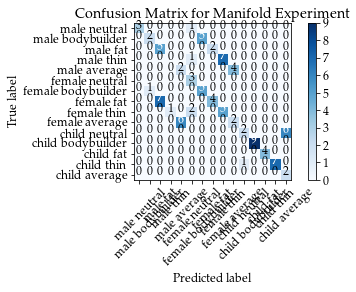

In [59]:
plt.imshow(C, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix for Manifold Experiment')
plt.colorbar()



classes = [label(20*x) for x in range(15)]
classes = [c.replace('_',' ') for c in classes]
print(classes)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = C.max() / 2.
for i, j in itertools.product(range(C.shape[0]), range(C.shape[1])):
    plt.text(j, i, format(C[i, j], fmt),
             horizontalalignment="center",
             color="white" if C[i, j] > thresh else "black")


    
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig.set_size_inches(18.5, 10.5)

plt.savefig('../Figures/ShapeData_Confusion.pdf')


['male neutral', 'male bodybuilder', 'male fat', 'male thin', 'male average', 'female neutral', 'female bodybuilder', 'female fat', 'female thin', 'female average', 'child neutral', 'child bodybuilder', 'child fat', 'child thin', 'child average']


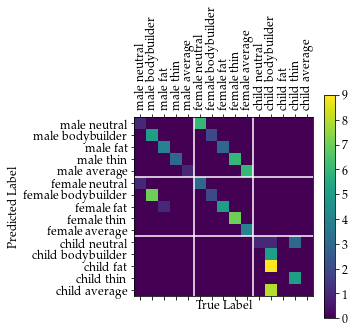

In [82]:
im = plt.matshow(C)
tick_marks = np.arange(len(classes))
plt.colorbar(im)

classes = [label(20*x) for x in range(15)]
classes = [c.replace('_',' ') for c in classes]
print(classes)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.plot([-.5,14.5],[4.5,4.5],c='white')
plt.plot([-.5,14.5],[9.5,9.5],c='white')
plt.plot([4.5,4.5],[-.5,14.5],c='white')
plt.plot([9.5,9.5],[-.5,14.5],c='white')

---
Beginning experiment.
Variables in parameter bucket
---
description : 
d : 10
delta : 46.1273
epsilon : 0.0
maxPower : 2
clfClass : <class 'sklearn.linear_model.ridge.RidgeClassifierCV'>
seed : 48864
test_size : 0.33
---

Using 201/300 to train...
Training estimator.
Making G...
	Creating row 200 out of 201...
Number of features used is 6215 ...
Trained estimator. Time taken is 0 hrs, 0 min, 38 secs.

Checking score on training set...
Score on training set: 0.945273631841.

Using 99/300 to test...
	Creating row 98 out of 99...
Score on testing set: 0.646464646465...

Finished with train/test experiment.


# Old: Trying to load in data directly

In [2]:
# Eventually replace with:
# from teaspoon.Misc import getAllFilenames

def getAllFilenames(folderPath=os.getcwd(), filetype='.mat'):
    cwd = folderPath
    filenames = os.listdir(cwd)
    if len(filetype) >0:
        filenames = [f for f in filenames if f[-len(filetype):] == filetype]
    return filenames

In [3]:
cd UliPaperData/syntethic_hks_diagrams/

/home/muncheli/Dropbox/Math/ResearchProjects/StatisticsOnPers/Papers/mlwithtents/NotebooksForExperiments/UliPaperData/syntethic_hks_diagrams


In [21]:
filenames = getAllFilenames(folderPath = os.getcwd(),
                            filetype = '.diagram')

In [22]:
filenames

['234_freq_5.diagram',
 '276_freq_5.diagram',
 '200_freq_9.diagram',
 '130_freq_3.diagram',
 '138_freq_7.diagram',
 '280_freq_3.diagram',
 '192_freq_5.diagram',
 '241_freq_7.diagram',
 '285_freq_1.diagram',
 '205_freq_6.diagram',
 '195_freq_4.diagram',
 '276_freq_1.diagram',
 '89_freq_2.diagram',
 '158_freq_8.diagram',
 '177_freq_2.diagram',
 '148_freq_2.diagram',
 '197_freq_1.diagram',
 '150_freq_4.diagram',
 '12_freq_5.diagram',
 '148_freq_4.diagram',
 '215_freq_3.diagram',
 '250_freq_1.diagram',
 '139_freq_4.diagram',
 '281_freq_8.diagram',
 '180_freq_3.diagram',
 '156_freq_2.diagram',
 '73_freq_1.diagram',
 '25_freq_10.diagram',
 '18_freq_3.diagram',
 '114_freq_4.diagram',
 '277_freq_6.diagram',
 '41_freq_4.diagram',
 '290_freq_7.diagram',
 '298_freq_8.diagram',
 '247_freq_4.diagram',
 '37_freq_8.diagram',
 '148_freq_1.diagram',
 '292_freq_8.diagram',
 '216_freq_4.diagram',
 '223_freq_8.diagram',
 '198_freq_1.diagram',
 '161_freq_3.diagram',
 '265_freq_2.diagram',
 '203_freq_5.diag

In [47]:
def readDIPHA(Dgm):
    assert Dgm[0] == 8067171840, 'This is not a DIPHA file'
    assert Dgm[1] == 2, 'This must be some other DIPHA filetype. This entry should be 2 if it comes from a persistence diagram.'
    numPairs = Dgm[2]
    outDgm = Dgm[3:].reshape(numPairs,3)
    return outDgm
    
# TODO What on earth is the dimension thing doing?
# TODO How do we convert the double precision numbers into "correct"

In [48]:
DgmsDF = pd.DataFrame(columns = ['Placeholder','Dgm'],
                      index = filenames)
for filename in filenames:
    data_array = np.fromfile(filename,np.int64)
    DgmsDF.Dgm[filename] = readDIPHA(data_array) 
DgmsDF.head()

,Placeholder,Dgm
234_freq_5.diagram,NaN,"[[-2, 4623716560452929946, 4630743181483450918..."
276_freq_5.diagram,NaN,"[[-2, 4624220346227817676, 4632491075007201453..."
200_freq_9.diagram,NaN,"[[-2, 4616551439792709239, 4616610662196254214..."
130_freq_3.diagram,NaN,"[[-2, 4627623354678858403, 4635972684205792565..."
138_freq_7.diagram,NaN,"[[-2, 4616437674140827125, 4623165357217442242..."


In [36]:
DgmExample = DgmsDF.Dgm[0]
DgmExample

array([         8067171840,                   2,                  26,
                        -2, 4623716560452929946, 4630743181483450918,
                        -2, 4624036262437179083, 4630743181483450918,
                        -1, 4616472525960070873, 4630743181483450918,
                         1, 4618062447936757154, 4630480681718742861,
                         1, 4618601997735523685, 4630743181483450918,
                         1, 4618746060877296767, 4630690141499677890,
                         1, 4619625002001674431, 4630478660094382572,
                         1, 4624039927181590993, 4624883515965255843,
                         1, 4624881039925918113, 4624886890175337955,
                         1, 4624989934456440929, 4624990349373780320,
                         1, 4630174334237555362, 4630241427693418163,
                         1, 4630223331678700774, 4630287783537871665,
                         1, 4630331591961837007, 4630332464577053651,
                    

In [40]:
readDIPHA(DgmExample[1:])

AssertionError: This is not a DIPHA file

In [42]:
len(DgmExample[3:])

78

In [43]:
78/26

3.0

In [46]:
test = DgmExample[3:].reshape(26,3)
TestDF = pd.DataFrame(test,columns = ['Dim', 'Birth','Death'])
TestDF


,Dim,Birth,Death
0,-2,4623716560452929946,4630743181483450918
1,-2,4624036262437179083,4630743181483450918
2,-1,4616472525960070873,4630743181483450918
3,1,4618062447936757154,4630480681718742861
4,1,4618601997735523685,4630743181483450918
5,1,4618746060877296767,4630690141499677890
6,1,4619625002001674431,4630478660094382572
7,1,4624039927181590993,4624883515965255843
8,1,4624881039925918113,4624886890175337955
9,1,4624989934456440929,4624990349373780320
